## Problem Statement

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [ ]:
pip install nltk

In [ ]:
import json
import numpy as np
import pandas as pd

import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from pprint import pprint

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, f1_score, classification_report

from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS

In [ ]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [ ]:
# Opening JSON file
from google.colab import drive
drive.mount('/content/drive')

f = open('/content/drive/MyDrive/ticket_classification/complaints-2021-05-14_08_16.json')


# returns JSON object as
# a dictionary
data = json.load(f)
df=pd.json_normalize(data)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df.head()


,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [ ]:
df.shape


(78313, 22)

## Data preparation

## The dataset has 78,313 customer complaints and 22 features

In [ ]:
list(df.columns)

['_index',
 '_type',
 '_id',
 '_score',
 '_source.tags',
 '_source.zip_code',
 '_source.complaint_id',
 '_source.issue',
 '_source.date_received',
 '_source.state',
 '_source.consumer_disputed',
 '_source.product',
 '_source.company_response',
 '_source.company',
 '_source.submitted_via',
 '_source.date_sent_to_company',
 '_source.company_public_response',
 '_source.sub_product',
 '_source.timely',
 '_source.complaint_what_happened',
 '_source.sub_issue',
 '_source.consumer_consent_provided']

In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [ ]:
df.describe()


,_score
count,78313.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


In [ ]:
df.isna().sum(0)

_index                                   0
_type                                    0
_id                                      0
_score                                   0
_source.tags                         67413
_source.zip_code                      6757
_source.complaint_id                     0
_source.issue                            0
_source.date_received                    0
_source.state                         1991
_source.consumer_disputed                0
_source.product                          0
_source.company_response                 0
_source.company                          0
_source.submitted_via                    0
_source.date_sent_to_company             0
_source.company_public_response      78309
_source.sub_product                  10571
_source.timely                           0
_source.complaint_what_happened          0
_source.sub_issue                    46297
_source.consumer_consent_provided     1008
dtype: int64

In [ ]:
## There are a lot of missing values. However, they are in columns that will not be required in model building, so we leave them untreated.

In [ ]:
#Assign new column names
df.columns = [re.sub('^_', '', col) for col in df.columns]  #replacing _ with blank space
list(df.columns)



['index',
 'type',
 'id',
 'score',
 'source.tags',
 'source.zip_code',
 'source.complaint_id',
 'source.issue',
 'source.date_received',
 'source.state',
 'source.consumer_disputed',
 'source.product',
 'source.company_response',
 'source.company',
 'source.submitted_via',
 'source.date_sent_to_company',
 'source.company_public_response',
 'source.sub_product',
 'source.timely',
 'source.complaint_what_happened',
 'source.sub_issue',
 'source.consumer_consent_provided']

In [ ]:
df.columns = [re.sub(r"^\bsource\b\.", "", col) for col in df.columns] #removing "source" from the code
list(df.columns)

['index',
 'type',
 'id',
 'score',
 'tags',
 'zip_code',
 'complaint_id',
 'issue',
 'date_received',
 'state',
 'consumer_disputed',
 'product',
 'company_response',
 'company',
 'submitted_via',
 'date_sent_to_company',
 'company_public_response',
 'sub_product',
 'timely',
 'complaint_what_happened',
 'sub_issue',
 'consumer_consent_provided']

In [ ]:
df.head()


,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [ ]:
#Assign nan in place of blanks in the complaints column
len(df[df['complaint_what_happened'] == ""])


57241

In [ ]:
#Remove all rows where complaints column is nan
df['complaint_what_happened'].replace("", np.nan, inplace=True)
df.dropna(subset=['complaint_what_happened'], inplace=True)
len(df[df['complaint_what_happened'] == ""])


0

In [ ]:
## View the shape of modified dataframe
df.shape


(21072, 22)

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [ ]:
df['complaint_what_happened'].head()


1     Good morning my name is XXXX XXXX and I apprec...
2     I upgraded my XXXX XXXX card in XX/XX/2018 and...
10    Chase Card was reported on XX/XX/2019. However...
11    On XX/XX/2018, while trying to book a XXXX  XX...
14    my grand son give me check for {$1600.00} i de...
Name: complaint_what_happened, dtype: object

In [ ]:
# Write your function here to clean the text and remove all the unnecessary elements.
## makes the given text lowercase, removes text in square brackets, removes punctuation and removes words containing numbers.
def clean_text(text):


    # Make the text lowercase
    text = text.lower()

    # Remove text in square brackets
    text = re.sub(r'\[.*?\]', '', text)

    # Remove punctuation
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)

    # Remove words containing numbers
    text = re.sub(r'\w*\d\w*', '', text)

    return text

In [ ]:
df_clean = pd.DataFrame(df['complaint_what_happened'].apply(lambda x: clean_text(x)))

df_clean.head()



,complaint_what_happened
1,good morning my name is xxxx xxxx and i apprec...
2,i upgraded my xxxx xxxx card in and was told ...
10,chase card was reported on however fraudulent...
11,on while trying to book a xxxx xxxx ticket ...
14,my grand son give me check for i deposit it i...


In [ ]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints
def lemmatizer(text):

    # Initialize empty list to store lemmas
    sent = []

    # Extract lemmas of given text and add to the list 'sent'
    doc = nlp(text)
    for word in doc:
        sent.append(word.lemma_)

    # return string converted form of the list of lemmas
    return " ".join(sent)

In [ ]:
# Add a column for lemmatized complaints to the dataframe
df_clean["lemmatized_complaint"] =  df_clean.apply(lambda x: lemmatizer(x['complaint_what_happened']), axis=1)

# View the dataframe
df_clean.head()

,complaint_what_happened,lemmatized_complaint
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...


In [ ]:
#Write your function to extract the POS tags

def pos_tag(text):
  # write your code here
  blob = TextBlob(text)

  # extract words with tags 'NN', join them and return
  return ' '.join([ word for (word,tag) in blob.tags if tag == "NN"])


df_clean["complaint_POS_removed"] = df_clean.apply(lambda x: pos_tag(x['lemmatized_complaint']), axis=1)
 #this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].


In [ ]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...
...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,card customer decade solicitation credit card ...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...,visa credit card provider claim purchase prote...
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk provide consumer bank app chase year ...
78311,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yrs I ve hav...,credit yrs credit card chase freedom xxxx prob...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




Text(0, 0.5, 'Number of Complaints')

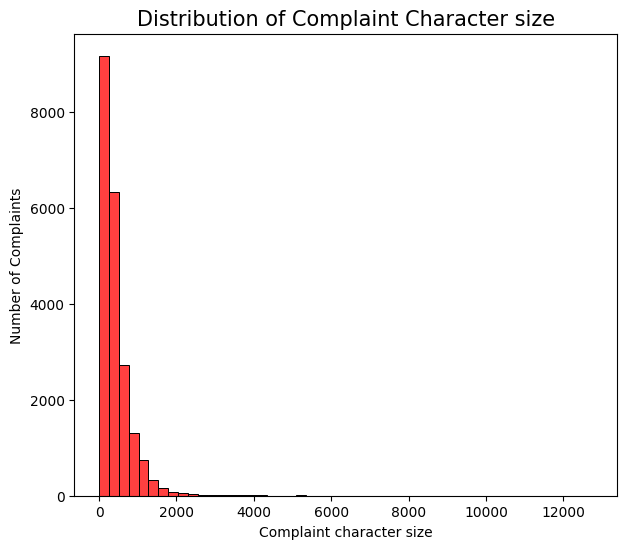

In [ ]:
# Write your code here to visualise the data according to the 'Complaint' character length

char_len=[len(x) for x in df_clean['complaint_POS_removed']]
plt.figure(figsize=[7,6])
sns.histplot(data = char_len,bins=50,color='red')
plt.title('Distribution of Complaint Character size', fontsize=15)
plt.xlabel('Complaint character size',size=10)
plt.ylabel('Number of Complaints',size=10)

#### Find the top 40 words by frequency among all the articles after processing the text.

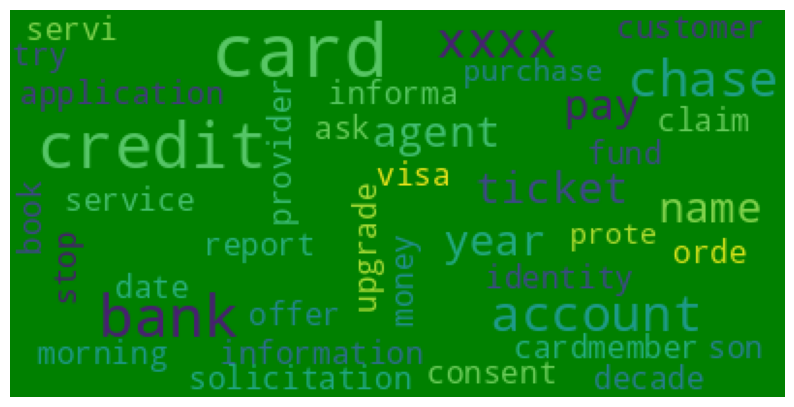

In [ ]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
word_cloud = WordCloud(
                          background_color='green',
                          max_font_size=38,
                          max_words=40,
                          random_state=42
                         ).generate(str(df_clean['complaint_POS_removed']))

fig = plt.figure(figsize=(10,10))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

In [ ]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [ ]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean).
def top_unigram(text, n=30):

    vector = CountVectorizer(stop_words='english').fit(text)
    bag_of_words = vector.transform(text)
    sum_of_words = bag_of_words.sum(axis=0)
    word_freq = [(word, sum_of_words[0, idx]) for word, idx in vector.vocabulary_.items()]
    word_freq =sorted(word_freq, key = lambda x: x[1], reverse=True)
    return word_freq[:n]

,unigram,count
0,account,47516
1,chase,46699
2,xxxx,36564
3,credit,34148
4,card,29278


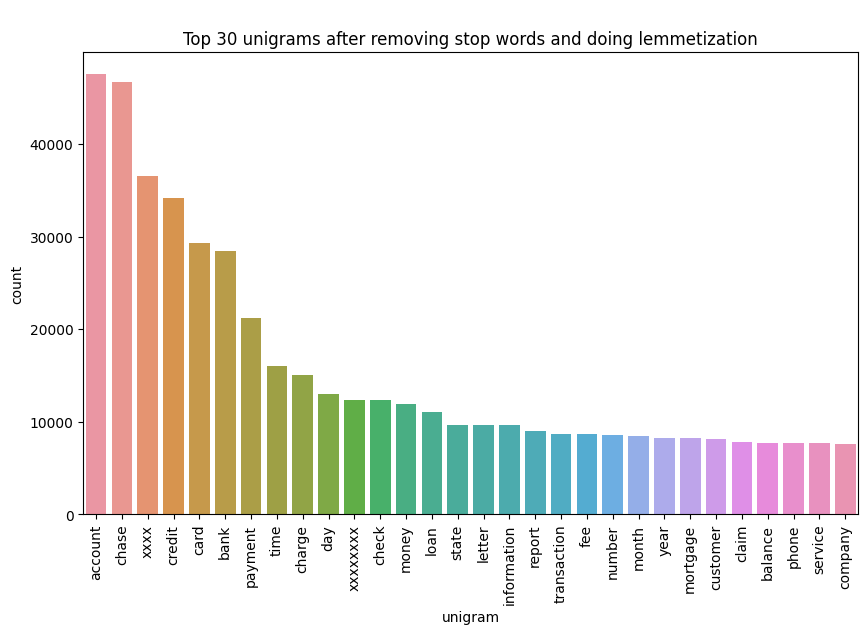

In [ ]:
#Print the top 10 words in the unigram frequency
most_common_words = top_unigram(df_clean['complaint_POS_removed'].values.astype('U'))
df_unigram = pd.DataFrame(most_common_words, columns = ['unigram' , 'count'])
display(df_unigram.head(5))

plt.figure(figsize=(10,6))
sns.barplot(x='unigram', y='count', data=df_unigram)
plt.xticks(rotation=90)
plt.title("\nTop 30 unigrams after removing stop words and doing lemmetization", fontsize=12)
plt.show()

In [ ]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean).
def top_bigram(text, n=30):

    vector = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(text)
    bag_of_words = vector.transform(text)
    sum_of_words = bag_of_words.sum(axis=0)
    word_freq = [(word, sum_of_words[0, idx]) for word, idx in vector.vocabulary_.items()]
    word_freq =sorted(word_freq, key = lambda x: x[1], reverse=True)
    return word_freq[:n]

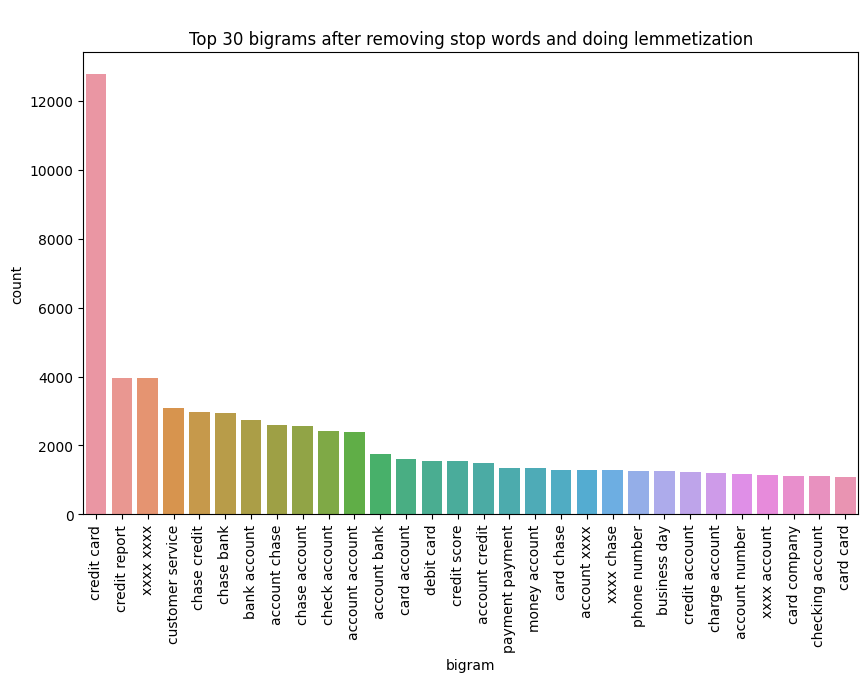

In [ ]:
#Print the top 10 words in the bigram frequency
most_common_words = top_bigram(df_clean['complaint_POS_removed'].values.astype('U'))
df_bigram = pd.DataFrame(most_common_words, columns = ['bigram' , 'count'])
df_bigram.head(5)

plt.figure(figsize=(10,6))
sns.barplot(x='bigram', y='count', data=df_bigram)
plt.xticks(rotation=90)
plt.title("\nTop 30 bigrams after removing stop words and doing lemmetization", fontsize=12)
plt.show()

In [ ]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean).
def top_trigram(text, n=30):

    vector = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(text)
    bag_of_words = vector.transform(text)
    sum_of_words = bag_of_words.sum(axis=0)
    word_freq = [(word, sum_of_words[0, idx]) for word, idx in vector.vocabulary_.items()]
    word_freq =sorted(word_freq, key = lambda x: x[1], reverse=True)
    return word_freq[:n]

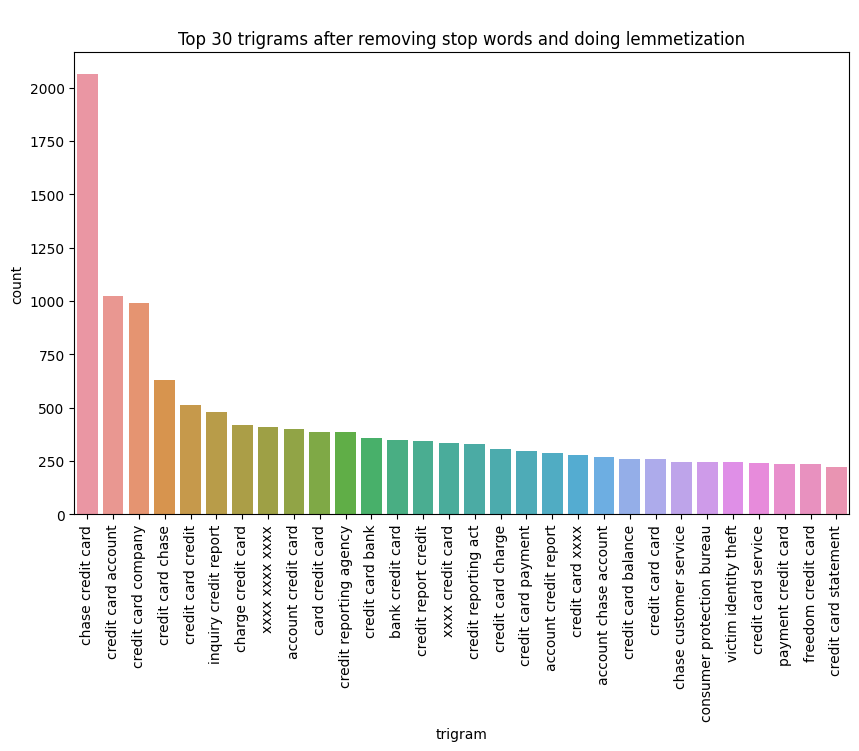

In [ ]:
#Print the top 10 words in the trigram frequency
most_common_words = top_trigram(df_clean['complaint_POS_removed'].values.astype('U'))
df_trigram = pd.DataFrame(most_common_words, columns = ['trigram' , 'count'])
df_trigram.head(5)

plt.figure(figsize=(10,6))
sns.barplot(x='trigram', y='count', data=df_trigram)
plt.xticks(rotation=90)
plt.title("\nTop 30 trigrams after removing stop words and doing lemmetization", fontsize=12)
plt.show()

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [ ]:
#replacing xxxx with null string
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [ ]:
#All masked texts has been removed
df_clean

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...
...,...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,card customer decade solicitation credit card ...,card customer decade solicitation credit card ...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...,visa credit card provider claim purchase prote...,visa credit card provider claim purchase prote...
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk provide consumer bank app chase year ...,pay risk provide consumer bank app chase year ...
78311,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yrs I ve hav...,credit yrs credit card chase freedom xxxx prob...,credit yrs credit card chase freedom problem ...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [ ]:
#Write your code here to initialise the TfidfVectorizer

tf_idf=TfidfVectorizer(max_df=0.95,min_df=2,stop_words='english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [ ]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm=tf_idf.fit_transform(df_clean['complaint_POS_removed'])

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints
* Correct the labels if needed
* Map the clusters to topics/cluster names

In [ ]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [ ]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5 #write the value you want to test out

#keep the random_state = 40
nmf_model = NMF(n_components=5,random_state=40) #write your code here

In [ ]:
nmf_model.fit(dtm)
len(tf_idf.get_feature_names_out())

7364

In [ ]:
#Print the Top15 words for each of the topics
for index, topic in enumerate(nmf_model.components_):
    print(f'TOP MOST 15 WORDS FOR TOPIC #{index}')
    print([tf_idf.get_feature_names_out()[i] for i in topic.argsort()[-15:]])
    print('\n')

TOP MOST 15 WORDS FOR TOPIC #0
['customer', 'transfer', 'transaction', 'business', 'number', 'day', 'branch', 'xxxx', 'deposit', 'chase', 'fund', 'money', 'bank', 'check', 'account']


TOP MOST 15 WORDS FOR TOPIC #1
['letter', 'year', 'balance', 'application', 'debt', 'information', 'limit', 'company', 'score', 'account', 'chase', 'inquiry', 'report', 'card', 'credit']


TOP MOST 15 WORDS FOR TOPIC #2
['foreclosure', 'house', 'bank', 'document', 'time', 'rate', 'letter', 'year', 'property', 'chase', 'modification', 'home', 'xxxx', 'mortgage', 'loan']


TOP MOST 15 WORDS FOR TOPIC #3
['refund', 'time', 'service', 'xxxxxxxx', 'purchase', 'fraud', 'claim', 'merchant', 'xxxx', 'fee', 'chase', 'dispute', 'transaction', 'card', 'charge']


TOP MOST 15 WORDS FOR TOPIC #4
['chase', 'account', 'credit', 'xxxx', 'pay', 'date', 'auto', 'time', 'xxxxxxxx', 'day', 'statement', 'fee', 'month', 'balance', 'payment']




In [ ]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4

result_for_topic = nmf_model.transform(dtm)
result_for_topic[0].round(2)
result_for_topic[0].argmax()
result_for_topic.argmax(axis=1)

array([0, 3, 1, ..., 3, 4, 4])

In [ ]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = result_for_topic.argmax(axis=1)

In [ ]:
df_clean.head()

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,0
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,3
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...,1
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...,1
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,0


In [ ]:
#Print the first 5 Complaint for each of the Topics
df_clean_grp=df_clean.groupby('Topic').head(5)
df_clean_grp.sort_values('Topic')

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,0
24,mishandling of this account by chase auto and ...,mishandle of this account by chase auto and xxxx,mishandle account auto xxxx,mishandle account auto,0
17,with out notice jp morgan chase restricted my ...,with out notice jp morgan chase restrict my ac...,jp chase account debit card tuesday thursday b...,jp chase account debit card tuesday thursday b...,0
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,0
27,i opened an account with chase bank on xxxx an...,I open an account with chase bank on xxxx and ...,account bank code bonus term everything accoun...,account bank code bonus term everything accoun...,0
15,can you please remove inquiry,can you please remove inquiry,inquiry,inquiry,1
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...,1
23,i have a chase credit card which is incorrectl...,I have a chase credit card which be incorrectl...,chase credit card datum credit report company ...,chase credit card datum credit report company ...,1
26,i have reached out to xxxx several times in at...,I have reach out to xxxx several time in attem...,time attempt inquiry creditor place inquiry re...,time attempt inquiry creditor place inquiry re...,1
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [ ]:
df_x = df_clean.copy(deep=True)

In [ ]:
#Create the dictionary of Topic names and Topics

Topic_names = {0:"Bank Account services",
               1:"Credit card or prepaid card",
               2:"Others",
               3:"Theft/Dispute Reporting",
               4:"Mortgage/Loan"}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [ ]:
df_clean

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,Bank Account services
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,Theft/Dispute Reporting
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...,Credit card or prepaid card
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...,Credit card or prepaid card
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,Bank Account services
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,card customer decade solicitation credit card ...,card customer decade solicitation credit card ...,Credit card or prepaid card
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...,visa credit card provider claim purchase prote...,visa credit card provider claim purchase prote...,Theft/Dispute Reporting
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk provide consumer bank app chase year ...,pay risk provide consumer bank app chase year ...,Theft/Dispute Reporting
78311,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yrs I ve hav...,credit yrs credit card chase freedom xxxx prob...,credit yrs credit card chase freedom problem ...,Mortgage/Loan


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [ ]:
#Create the dictionary again of Topic names and Topics

Topic_names = {"Bank Account services":0,
               "Credit card or prepaid card":1,
               "Others":2,
               "Theft/Dispute Reporting":3,
               "Mortgage/Loan":4}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [ ]:
df_clean

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,0
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,3
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...,1
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...,1
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,0
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,card customer decade solicitation credit card ...,card customer decade solicitation credit card ...,1
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...,visa credit card provider claim purchase prote...,visa credit card provider claim purchase prote...,3
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk provide consumer bank app chase year ...,pay risk provide consumer bank app chase year ...,3
78311,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yrs I ve hav...,credit yrs credit card chase freedom xxxx prob...,credit yrs credit card chase freedom problem ...,4


In [ ]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=df_clean[['complaint_what_happened','Topic']]

In [ ]:
training_data

,complaint_what_happened,Topic
1,good morning my name is xxxx xxxx and i apprec...,0
2,i upgraded my xxxx xxxx card in and was told ...,3
10,chase card was reported on however fraudulent...,1
11,on while trying to book a xxxx xxxx ticket ...,1
14,my grand son give me check for i deposit it i...,0
...,...,...
78303,after being a chase card customer for well ove...,1
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,3
78310,i am not familiar with xxxx pay and did not un...,3
78311,i have had flawless credit for yrs ive had ch...,4


In [ ]:
training_data.shape

(21072, 2)

####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [ ]:
#Write your code to get the Vector count
count_vector=CountVectorizer()

#Write your code here to transform the word vector to tf-idf
X_train_count=count_vector.fit_transform(training_data['complaint_what_happened'])

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [ ]:
import pickle

pickle.dump(count_vector.vocabulary_, open("count_vector.pkl","wb"))

In [ ]:
# Transform the word vector to tf-idf
tfidf_transform= TfidfTransformer()
X_train_tfidf = tfidf_transform.fit_transform(X_train_count)

In [ ]:
# Save TF-IDF on disk for later usage
pickle.dump(tfidf_transform, open("tfidf.pkl","wb"))

In [ ]:
#Splitting the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, test_size=0.25, random_state=42)

print(f"X_train Shape: {X_train.shape}")
print(f"y_train Shape: {y_train.shape}")
print(f"X_test Shape: {X_test.shape}")
print(f"y_test Shape: {y_test.shape}")

X_train Shape: (15804, 33599)
y_train Shape: (15804,)
X_test Shape: (5268, 33599)
y_test Shape: (5268,)


In [ ]:
# Create a function to evaluate models
def eval(y_test, y_pred, model_name):

    # print classification report of classifier
    print(f"CLASSIFICATION REPORT for {model_name}\n")
    print(classification_report(y_test, y_pred, target_names=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting",
"Mortgage/Loan"]))

    # plot confusion matrix of the classifier
    plt.figure(figsize=(10,7))
    plt.title(f"CONFUSION MATRIX for {model_name}\n")
    matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(matrix, annot=True, cbar=None, fmt='d', xticklabels=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting",
"Mortgage/Loan"], yticklabels=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting",
"Mortgage/Loan"])
    plt.show()

    return

**Model-1 : Naive Bayes**

In [ ]:
from sklearn.naive_bayes import MultinomialNB

model_name = 'Naive_Bayes'
nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)
# Hyperparameter tuning for best result
param_nb = {
    'alpha': (1, 0.1, 0.01, 0.001, 0.0001, 0.00001),
    'fit_prior':[True, False]
}

#using grid search to find the best parameters with 10 folds
grid_nb = GridSearchCV(estimator=nb,
                       param_grid=param_nb,
                       verbose=1,
                       scoring='f1_weighted',
                       n_jobs=-1,
                       cv=10)
grid_nb.fit(X_train, y_train)
print(grid_nb.best_params_, end="\n\n")

Fitting 10 folds for each of 12 candidates, totalling 120 fits
{'alpha': 0.1, 'fit_prior': False}



In [ ]:
#using the hyperparameter obtained to train the model
nb_tuned = MultinomialNB(alpha=0.1,fit_prior=False)
nb_tuned.fit(X_train, y_train)
y_pred_nb_tuned = nb_tuned.predict(X_test)
# Calculate F1 Score of model using weighted average method
f1_nb = f1_score(y_test, y_pred_nb_tuned, average="weighted")
f1_nb

0.7812816003181667

CLASSIFICATION REPORT for Naive_Bayes

                             precision    recall  f1-score   support

      Bank Account services       0.78      0.84      0.81      1289
Credit card or prepaid card       0.80      0.76      0.78      1247
                     Others       0.82      0.85      0.84       908
    Theft/Dispute Reporting       0.77      0.77      0.77      1282
              Mortgage/Loan       0.69      0.61      0.65       542

                   accuracy                           0.78      5268
                  macro avg       0.77      0.77      0.77      5268
               weighted avg       0.78      0.78      0.78      5268



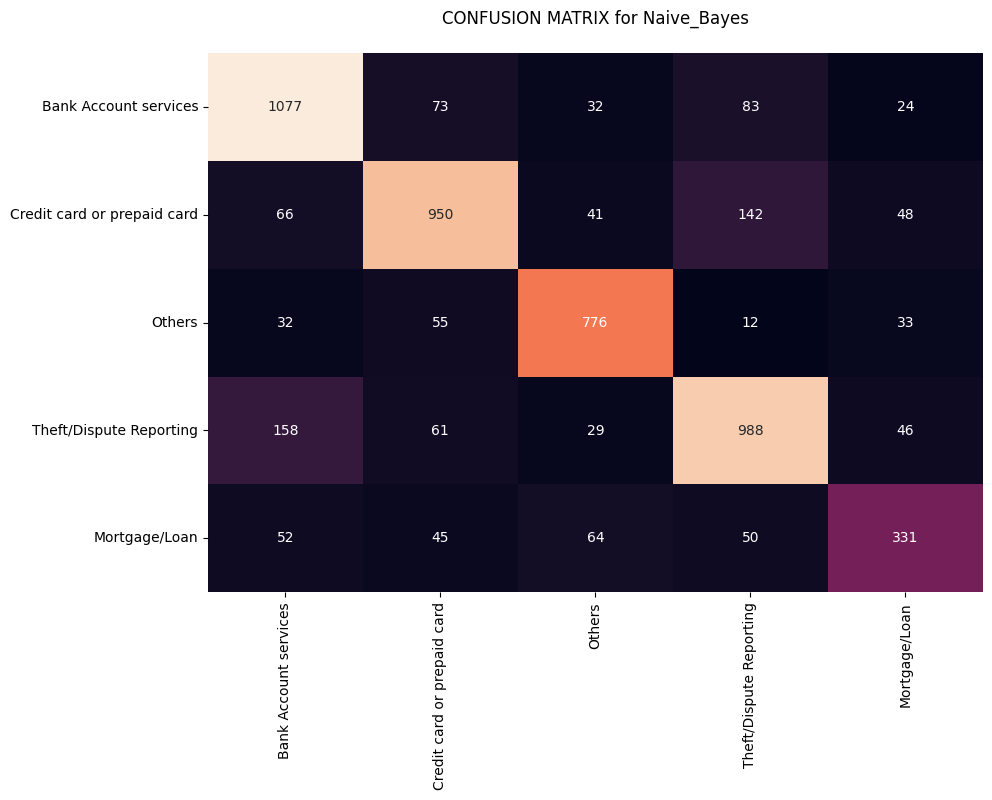

In [ ]:
# Evaluate the Naive Bayes classifier
eval(y_test, y_pred_nb_tuned, model_name)

In [ ]:
# Create a dataframe to store F1 Scores of all models we will build
f1_summary = pd.DataFrame([{'Model': 'Naive Bayes','F1 Score': round(f1_nb, 2)}])
f1_summary

,Model,F1 Score
0,Naive Bayes,0.78


**Model-2 Logistic Reegression**

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
# Run the Logistic Regression model with default parameters
model_name = 'Logistic regression'
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
# Hyperparameter tuning for best result
param_lr = {
    'penalty': ['l2'],
    'C': [0.001,0.01,0.1,1,10,100],
    'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

grid_lr = GridSearchCV(estimator=lr,
                       param_grid=param_lr,
                       verbose=1,
                       scoring='f1_weighted',
                       n_jobs=-1,
                       cv=5)
grid_lr.fit(X_train, y_train)
print(grid_lr.best_params_)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Fitting 5 folds for each of 30 candidates, totalling 150 fits
{'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [ ]:
# Creating model with best hyperparameter
lr_tuned = LogisticRegression(C=1,
                                  penalty='l2',
                                  solver='saga')

lr_tuned.fit(X_train, y_train)
y_pred_lr_tuned = lr_tuned.predict(X_test)
# Calculate F1 Score of tuned model using weighted average method
f1_lr = f1_score(y_test, y_pred_lr_tuned, average="weighted")
f1_lr

0.9217365303032916

CLASSIFICATION REPORT for Logistic regression

                             precision    recall  f1-score   support

      Bank Account services       0.93      0.94      0.94      1289
Credit card or prepaid card       0.93      0.93      0.93      1247
                     Others       0.92      0.93      0.93       908
    Theft/Dispute Reporting       0.90      0.91      0.90      1282
              Mortgage/Loan       0.96      0.87      0.91       542

                   accuracy                           0.92      5268
                  macro avg       0.93      0.92      0.92      5268
               weighted avg       0.92      0.92      0.92      5268



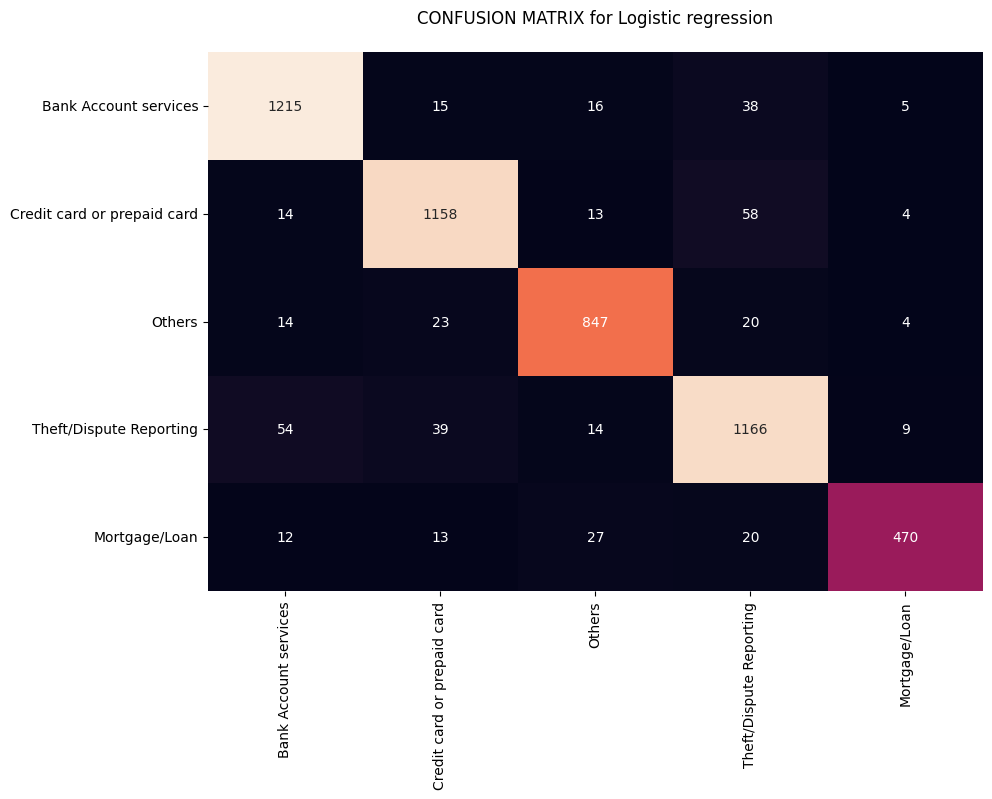

In [ ]:
eval(y_test, y_pred_lr_tuned, model_name)

In [ ]:
f1_summary.loc[len(f1_summary.index)] = ['Logistic Regression', round(f1_lr, 2)]
f1_summary

,Model,F1 Score
0,Naive Bayes,0.78
1,Logistic Regression,0.92


**Model-3: Decision Tree**

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
model_name = 'Decision tree'
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred_dt =dt.predict(X_test)
# Hyperparameter tuning for best result
param_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth' : [5, 10, 15, 20],
    'min_samples_leaf':[1,5,10,15,20],

}

grid_dt = GridSearchCV(estimator=dt,
                       param_grid=param_dt,
                       verbose=1,
                       scoring='f1_weighted',
                       n_jobs=-1,
                       cv=5)
grid_dt.fit(X_train, y_train)
print(grid_dt.best_params_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
{'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 20}


In [ ]:
# Creating model with best hyperparameter
dt_tuned = DecisionTreeClassifier(criterion='gini',
                                      max_depth=25,
                                      min_samples_leaf=15,
                                      )
dt_tuned.fit(X_train, y_train)
y_pred_dt_tuned = dt_tuned.predict(X_test)
# Calculate F1 Score of tuned model using weighted average method
f1_dt = f1_score(y_test, y_pred_dt_tuned, average="weighted")
f1_dt

0.7903478916826026

CLASSIFICATION REPORT for Decision tree

                             precision    recall  f1-score   support

      Bank Account services       0.79      0.82      0.80      1289
Credit card or prepaid card       0.81      0.83      0.82      1247
                     Others       0.79      0.82      0.81       908
    Theft/Dispute Reporting       0.78      0.71      0.75      1282
              Mortgage/Loan       0.77      0.78      0.78       542

                   accuracy                           0.79      5268
                  macro avg       0.79      0.79      0.79      5268
               weighted avg       0.79      0.79      0.79      5268



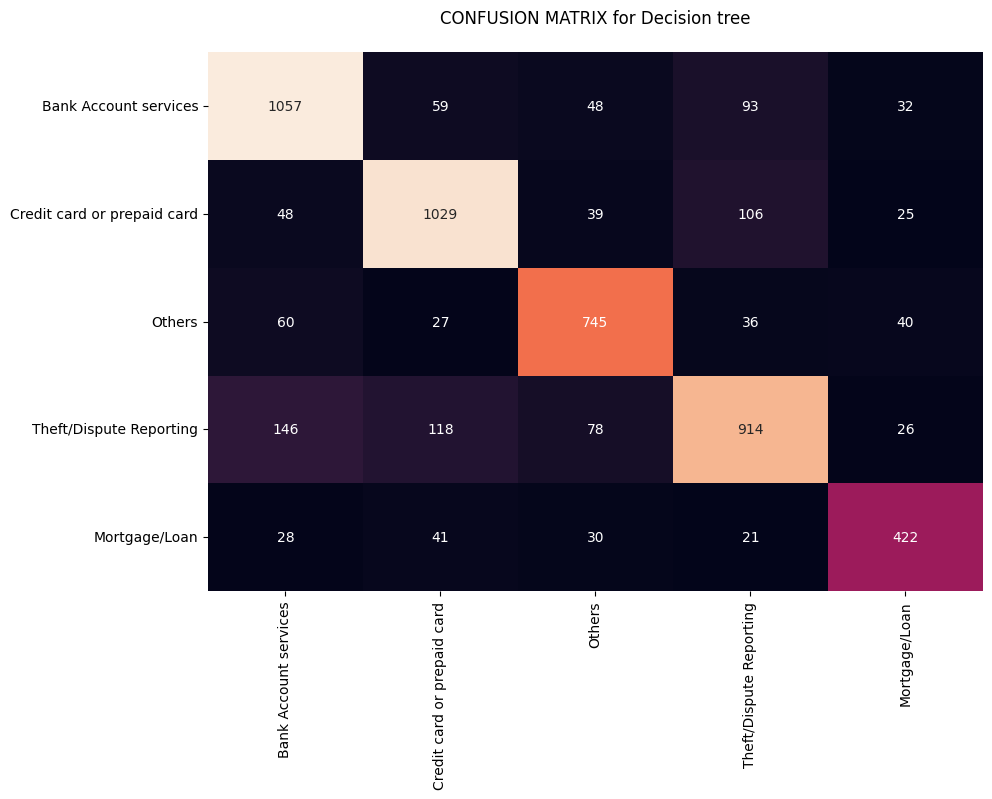

In [ ]:
eval(y_test, y_pred_dt_tuned, model_name)

In [ ]:
# Update the summary table
f1_summary.loc[len(f1_summary.index)] = ['Decision Tree', round(f1_dt, 2)]
f1_summary

,Model,F1 Score
0,Naive Bayes,0.78
1,Logistic Regression,0.92
2,Decision Tree,0.79


In [ ]:
## We can see that the logistic regression model performs the best

In [ ]:
pickle.dump(lr_tuned, open("logreg_model.pkl", "wb"))

**TESTING THE MODEL WITH CUSTOMER COMPLAINTS**

In [ ]:
def topic_predicter(text):

    target_names = ["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting", "Mortgage/Loan"]

    load_vec = CountVectorizer(vocabulary=pickle.load(open("count_vector.pkl", "rb")))
    load_tfidf = pickle.load(open("tfidf.pkl","rb"))
    load_model = pickle.load(open("logreg_model.pkl","rb"))

    X_new_count = load_vec.transform(text)
    X_new_tfidf = load_tfidf.transform(X_new_count)
    prediction = load_model.predict(X_new_tfidf)

    return target_names[prediction[0]]

In [ ]:
# Create a dataframe of some sample customer complaints
df_custom = pd.DataFrame({'complaints': ["I can not get from chase who services my mortgage, who owns it and who has original loan docs",
                                  "The bill amount of my credit card was debited twice. Please look into the matter and resolve at the earliest.",
                                  "I want to open a salary account at your downtown branch. Please provide me the procedure.",
                                  "unwanted service activated and money deducted automatically ",
                                  "How can I know my CIBIL score?",
                                  "Where are the bank branches in the city of Patna?"]})
df_custom

,complaints
0,I can not get from chase who services my mortg...
1,The bill amount of my credit card was debited ...
2,I want to open a salary account at your downto...
3,unwanted service activated and money deducted ...
4,How can I know my CIBIL score?
5,Where are the bank branches in the city of Patna?


In [ ]:
# Create a new column of predicted topics of each complaint, predicted using the tuned Logistic Regression model
df_custom['predicted topic'] = df_custom['complaints'].apply(lambda x: topic_predicter([x]))
df_custom

,complaints,predicted topic
0,I can not get from chase who services my mortg...,Others
1,The bill amount of my credit card was debited ...,Credit card or prepaid card
2,I want to open a salary account at your downto...,Bank Account services
3,unwanted service activated and money deducted ...,Bank Account services
4,How can I know my CIBIL score?,Credit card or prepaid card
5,Where are the bank branches in the city of Patna?,Bank Account services
